In [1]:
#load the required packages
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

Loading required package: carData

#refugeeswelcome

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::recode() masks car::recode()
✖ dplyr::select() masks MASS::select()
✖ purrr::some()   masks car::some()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [2]:
#VALUEdata=read.csv(choose.files())
QPCRdata=read.csv("raw_data/2^-ddCT.csv", sep=",")
QPCRdata$QPCR <- as.numeric(as.character(QPCRdata$QPCR))

print(head(QPCRdata))

  Treatment       QPCR Trial
1  A00flg20  0.8350879   One
2  A00flg20  1.1407637   One
3  A00flg20  1.0497167   One
4     flg22 53.4456268   One
5     flg22 58.0812259   One
6     flg22 55.3303828   One


[1] 135 137

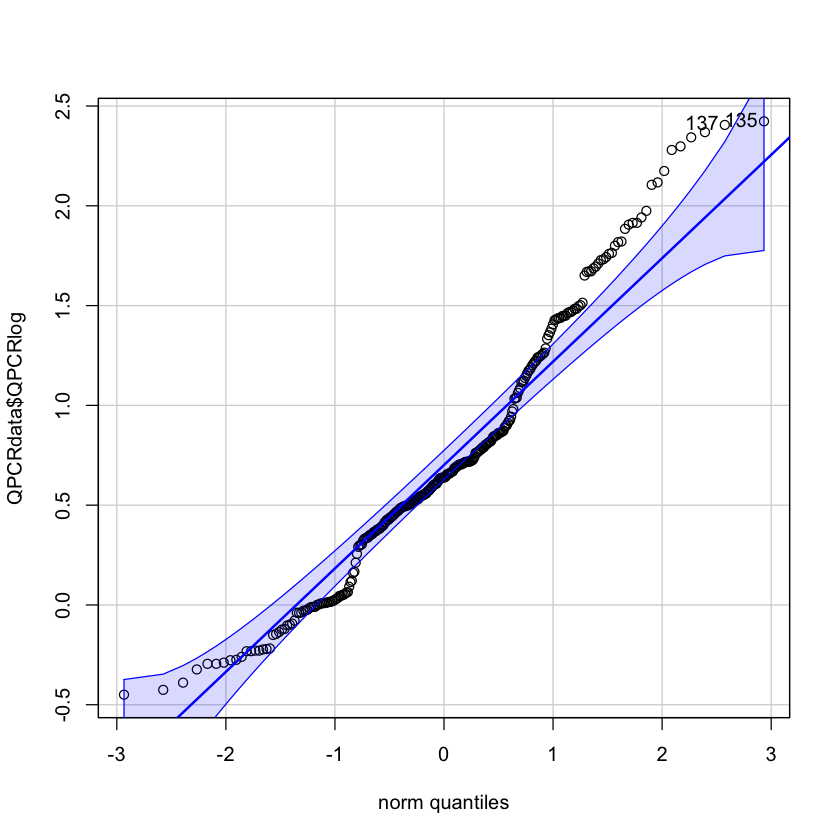

In [3]:
# Q-Q Plot for normality check
QPCRdata$QPCRlog <- log10(QPCRdata$QPCR)
qqp(QPCRdata$QPCRlog, "norm")

Warning message:
“Model was not fitted by REML. Re-fitting model using REML, but p-values, df, etc. still might be unreliable.”


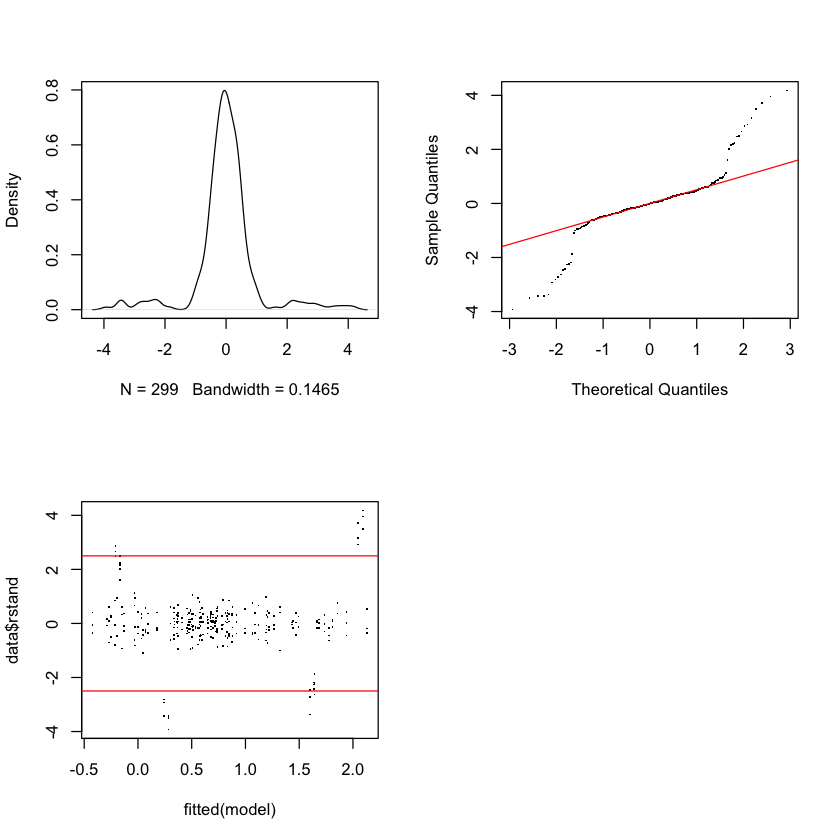

In [4]:
#first fit a linear mixed model, with Trial as the random effect
names(QPCRdata)[1] <- "Treatment"

#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
QPCRlog.lmm<-lmer(QPCRlog ~ Treatment + (1|Trial), data = QPCRdata, REML = FALSE)
m2<-lmer(QPCRlog ~ Treatment + (1|Trial), data = QPCRdata, REML = FALSE)
tab_model(m2, p.val = "kr", show.df = TRUE)

#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(QPCRlog.lmm)

In [5]:
#If the above looks good, then we can get the model characteristics
summary(QPCRlog.lmm)


Correlation matrix not shown by default, as p = 86 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: QPCRlog ~ Treatment + (1 | Trial)
   Data: QPCRdata

     AIC      BIC   logLik deviance df.resid 
  -448.0   -122.3    312.0   -624.0      211 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8840 -0.3338  0.0000  0.3401  4.1323 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept) 0.030510 0.17467 
 Residual             0.006345 0.07966 
Number of obs: 299, groups:  Trial, 8

Fixed effects:
                 Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     4.213e-12  6.386e-02  8.539e+00   0.000 1.000000    
TreatmentFIC01  3.349e-01  5.722e-02  2.953e+02   5.853 1.28e-08 ***
TreatmentFIC02  8.647e-01  5.722e-02  2.953e+02  15.113  < 2e-16 ***
TreatmentFIC03  1.472e+00  5.722e-02  2.953e+02  25.723  < 2e-16 ***
TreatmentFIC04  5.015e-01  5.722e-02  2.953e+02   8.764  < 2e-16 ***
TreatmentFIC05  1.350e+00  5.722e-02 

In [6]:
#anova analysis of lmm
aovlog <- anova(m2)
summary(aovlog)

     Sum Sq         Mean Sq          NumDF        DenDF          F value     
 Min.   :93.11   Min.   :1.095   Min.   :85   Min.   :291.2   Min.   :172.6  
 1st Qu.:93.11   1st Qu.:1.095   1st Qu.:85   1st Qu.:291.2   1st Qu.:172.6  
 Median :93.11   Median :1.095   Median :85   Median :291.2   Median :172.6  
 Mean   :93.11   Mean   :1.095   Mean   :85   Mean   :291.2   Mean   :172.6  
 3rd Qu.:93.11   3rd Qu.:1.095   3rd Qu.:85   3rd Qu.:291.2   3rd Qu.:172.6  
 Max.   :93.11   Max.   :1.095   Max.   :85   Max.   :291.2   Max.   :172.6  
     Pr(>F)          
 Min.   :2.409e-208  
 1st Qu.:2.409e-208  
 Median :2.409e-208  
 Mean   :2.409e-208  
 3rd Qu.:2.409e-208  
 Max.   :2.409e-208  

In [7]:
#Tukey's post-hoc, load library multcomp
multcompsm2 <- glht(m2, linfct = mcp(Treatment = "Tukey"))
# Perform summary on the glht object and store the result
summary_multcompsm2 <- summary(multcompsm2, test = adjusted("none"))
# Extract necessary information from the summary object
coefficients <- summary_multcompsm2$test$coefficients
p_values <- summary_multcompsm2$test$pvalues
# Combine coefficients and p-values into a data frame for easy viewing
result <- data.frame(Coefficients = coefficients, P_values = p_values)
# Display the first few rows of the result
print(head(result))

                 Coefficients     P_values
FIC01 - A00flg20  0.334892591 4.829098e-09
FIC02 - A00flg20  0.864705383 0.000000e+00
FIC03 - A00flg20  1.471782541 0.000000e+00
FIC04 - A00flg20  0.501462522 0.000000e+00
FIC05 - A00flg20  1.350367109 0.000000e+00
FIC06 - A00flg20  0.001752729 9.755625e-01


In [8]:
#Therefore the main effect Estimate called (Intercept) is the value for flg20, and if you are looking for treatments that out perform flg22 you should look for Estimates >0, in this case f19 but not significantly
QPCRdata$residuals <- residuals(m2)
#This makes new column contains residual differences
names(QPCRdata)[1] <- paste("Chemical")
str(QPCRdata)

'data.frame':	299 obs. of  5 variables:
 $ Chemical : chr  "A00flg20" "A00flg20" "A00flg20" "flg22" ...
 $ QPCR     : num  0.835 1.141 1.05 53.446 58.081 ...
 $ Trial    : chr  "One" "One" "One" "One" ...
 $ QPCRlog  : num  -0.0783 0.0572 0.0211 1.7279 1.764 ...
 $ residuals: num  -0.0474 0.088 0.0519 -0.05 -0.0139 ...


In [14]:
# Extract fixed effects coefficients
fixed_effects <- summary(QPCRlog.lmm)$coefficients
# Replace (Intercept) with flg20 in row names
row.names(fixed_effects)[row.names(fixed_effects) == "(Intercept)"] <- "flg20"
# Remove "Treatment" from row names
rownames(fixed_effects) <- gsub("^Treatment", "", rownames(fixed_effects))
# Convert to a data frame
qPCR_LMM_report <- as.data.frame(fixed_effects) %>%
  rownames_to_column(var = "Treatment") %>%
  mutate(LMM_value = 10^(Estimate - first(Estimate[Treatment == "flg20"]))) %>%
  arrange(Estimate) %>%
  select(Treatment, everything())
head(qPCR_LMM_report)

write.csv(qPCR_LMM_report, "raw_data/qPCR_LMM_report.csv", row.names = FALSE)

,Treatment,Estimate,Std. Error,df,t value,Pr(>|t|),LMM_value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FIC40,-0.47897059,0.05721768,295.3199,-8.371025,2.318246e-15,0.3319169
2,FIC55,-0.25287572,0.05721768,295.3199,-4.419538,1.390801e-05,0.5586300
3,FIC21,-0.25197637,0.05721768,295.3199,-4.403820,1.488818e-05,0.5597881
4,FIC10,-0.13056094,0.05721768,295.3199,-2.281829,2.321084e-02,0.7403534
5,FIC59,-0.09935042,0.05721768,295.3199,-1.736359,8.354325e-02,0.7955172
6,FIC79,-0.07920531,0.05721768,295.3199,-1.384280,1.673177e-01,0.8332872


In [24]:
# Select and transpose the data
qPCR_LMM_wide <- qPCR_LMM_report %>%
  select(Treatment, LMM_value) %>%
  t() %>%
  as.data.frame()

# Assign the first row as column names
colnames(qPCR_LMM_wide) <- unlist(qPCR_LMM_wide[1, ])
qPCR_LMM_wide <- qPCR_LMM_wide[-1, ]  # Remove the first row after assigning column names

head(qPCR_LMM_wide)

write.csv(qPCR_LMM_wide, "raw_data/qPCR_LMM_wide.csv", row.names = FALSE)

,FIC40,FIC55,FIC21,FIC10,FIC59,FIC79,FIC57,flg20,FIC06,FIC68,⋯,FIC05,FIC69,FIC32,FIC16,FIC35,FIC03,FIC28,FIC43,flg22,FIC26
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
LMM_value,0.3319169,0.5586300,0.5597881,0.7403534,0.7955172,0.8332872,0.9033133,1.0000000,1.0040440,1.1488727,⋯,22.4061433,24.9947348,26.4847605,26.9638129,27.8014949,29.6334722,31.1341047,45.2201580,64.3893419,77.9111132
